# Aufgabe 11 - Temporal-Difference Methods with Frozen Lake
18.01.2022, Thomas Iten

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.
While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

**Content**
0. Explore Frozen Lake
1. TD Control: Sarsa          (update_Q_sarsa)
2. TD Control: Q-learning     (update_Q_sarsamax, dito Q-Learing)
3. TD Control: Expected Sarsa (update_Q_expsarsa)

**References**
- https://colab.research.google.com/drive/1dloqQlR77yAIXEWgRGWSoSJXflMqCUuN?usp=sharing

## Part 0: Explore Frozen Lake

### Imports and Plot Helpers

In [1]:
import sys
import gym
import numpy as np
import random
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")


In [2]:
# from plot_utils import plot_values
def plot_values(V):
    # reshape the state-value function
    V = np.reshape(V, (4,4))
    # plot the state-value function
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(V, cmap='cool')
    for (j,i),label in np.ndenumerate(V):
        ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.title('State-Value Function')
    plt.show()


### Frozen Lake Helper

In [3]:
class FrozenLakeHelper():
    """Some helper methods used throughout this notebook."""

    def render(self, env, display_mode="brackets", print_result=True, legend=False):
        """
        IntelliJ notebooks to not render the color of the current position correct.
        Details see: https://youtrack.jetbrains.com/issue/PY-32191

        Therfore we use this customized render methode with two simple display modes.

        :param env: The current environment to render it's fields.
        :param display_mode: display current position with "brackets" or in "lowercase"
        :param print_result: print the last action and result
        :param legend: print the legend
        :return: lastaction as text and fields with marked current position
        """

        # init data
        row, col = env.s // env.ncol, env.s % env.ncol
        desc = env.desc.tolist()
        desc = [[c.decode("utf-8") for c in line] for line in desc]

        actions = ["Left", "Down", "Right", "Up"]
        action = "Init" if env.lastaction is None else actions[env.lastaction]

        # format display mode
        indicator = None
        if display_mode == "brackets":
            desc[row][col] = "[{}]".format(desc[row][col])
            desc = [[ (" {} ".format(c) if len(c) == 1 else c) for c in line ] for line in desc]
            indicator = "[]"
        elif display_mode == "lowercase":
            desc[row][col] = (desc[row][col]).lower()
            indicator = "lowercase"

        # print result
        if print_result:
            if legend:
                print("Last action:", action)
            else:
                print(action + ":")
            for line in desc:
                for pos in line:
                    print(pos, end="")
                print("")
            if legend:
                print("Legend: S=Start, F=Frozen (safe), H=Hole, G=Goal, " + indicator + "=Current Position")
            print("")

        # return result
        return action, desc


    def print_field_positions(self):
        print("Field positons:")
        print("[ 0] [ 1] [ 2] [ 3]")
        print("[ 4] [ 5] [ 6] [ 7]")
        print("[ 8] [09] [10] [11]")
        print("[12] [13] [14] [15]")

    def print_actions(self):
        print("Actions:")
        print("[0] Left")
        print("[1] Down")
        print("[2] Right")
        print("[3] Up")

    def print_Q(self, Q):
        print("Field: Left        Down       Right      Up")
        for field in Q:
            print(f"{field : >5}", end="")
            print(":", Q[field])

# Create helper instance
helper = FrozenLakeHelper()


### Frozen Lake environment

In [4]:
env = gym.make('FrozenLake-v1', is_slippery=False)

print("Action space:")
print(env.action_space)
print("")

helper.print_actions()
print("")

print("Observation space:")
print(env.observation_space)
print("")

helper.print_field_positions()


Action space:
Discrete(4)

Actions:
[0] Left
[1] Down
[2] Right
[3] Up

Observation space:
Discrete(16)

Field positons:
[ 0] [ 1] [ 2] [ 3]
[ 4] [ 5] [ 6] [ 7]
[ 8] [09] [10] [11]
[12] [13] [14] [15]


### Reset and initial state

In [5]:
env.reset()    # reset the environment the set agent to start state
helper.render(env, legend=True)
print()


Last action: Init
[S] F  F  F 
 F  H  F  H 
 F  F  F  H 
 H  F  F  G 
Legend: S=Start, F=Frozen (safe), H=Hole, G=Goal, []=Current Position




## Part 1: TD Control: Sarsa (update_Q_sarsa)

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the **estimated action value** corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

In [6]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None, plot=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target, gamma=discount
    new_value = current + (alpha * (target - current)) # get updated value, alpha analog=lr
    if plot:
        print("current:", current, "Qsa_next:", Qsa_next, "target:", target, "new_value:", new_value)
    return new_value


def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

In [7]:
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=1000):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    eps_decay = .99999
    eps = 1.
    eps_min = .05

    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        plot = False
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            print()
            plot = True
        score = 0                                             # initialize score
        state = env.reset()                                   # start episode
        
        # eps = 1.0 / i_episode
        eps = max(eps*eps_decay, eps_min)                     # set the value of epsilon

        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward                                   # add reward to agent's score
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action, plot)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  
If the code cell returns **PASSED**, then you have implemented the function correctly!
- Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.
- However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 100/5000
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.0 Qsa_next: 0.0 target: 0.0 new_value: 0.0
current: 0.

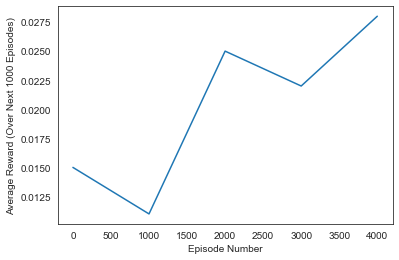

Best Average Reward over 1000 Episodes:  0.028
Field positons:
[ 0] [ 1] [ 2] [ 3]
[ 4] [ 5] [ 6] [ 7]
[ 8] [09] [10] [11]
[12] [13] [14] [15]

Field: Left        Down       Right      Up
    0: [0.00036658 0.00053297 0.00036279 0.00036923]
    1: [0.0003137  0.         0.0008616  0.00029001]
    2: [2.19523416e-04 3.58617675e-03 9.28536464e-05 6.27101368e-04]
    6: [0.         0.0190565  0.         0.00025419]
    4: [0.00045978 0.00138822 0.         0.00033049]
    3: [5.75745279e-04 0.00000000e+00 6.86102564e-05 3.16380065e-05]
   10: [0.00257729 0.11796505 0.         0.00113689]
   14: [0.01051799 0.07128434 0.63762798 0.00829868]
   13: [0.         0.00613391 0.08705229 0.00177983]
    9: [0.00069973 0.0112068  0.01481083 0.        ]
    8: [0.00100125 0.         0.00434374 0.00030811]



In [8]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)


helper.print_field_positions()
print()

helper.print_Q(Q_sarsa)
print()


In [49]:
# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(16)]).reshape(4,4)
#check_test.run_check('td_control_check', policy_sarsa)

# -1 sind löcher oder Goal, da kommt man gar nicht hinein, daher gibt es keine state/action paar
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A (Final state) = -1):")
print(policy_sarsa)



Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  1  0]
 [ 1 -1  1 -1]
 [ 2  2  1 -1]
 [-1  2  2 -1]]


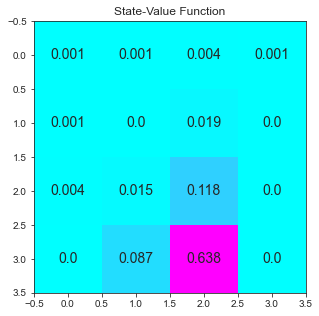

In [50]:
# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(16)])
plot_values(V_sarsa)

In [11]:
helper.print_actions()
print()

print("Policy:")
policy_sarsa

Actions:
[0] Left
[1] Down
[2] Right
[3] Up

Policy:


array([[ 1,  2,  1,  0],
       [ 1, -1,  1, -1],
       [ 2,  2,  1, -1],
       [-1,  2,  2, -1]], dtype=int64)

## Part 2: TD Control: Q-learning (update_Q_sarsamax)

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [12]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None, plot=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0  # value of next state 
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value

    if plot:
        print("current:", current, "Qsa_next:", Qsa_next, "target:", target, "new_value:", new_value)

    return new_value

In [33]:
def q_learning(env, num_episodes, alpha, gamma=0.9999, plot_every=1000):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes

    eps_decay = .99999
    eps = 1.
    eps_min = .05

    for i_episode in range(1, num_episodes+1):
        # monitor progress
        plot = False
        if i_episode % plot_every == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            print()
            plot = True
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode

        # eps = 1.0 / i_episode                                # epsilon divergiert zu schnell hier!
        eps = max(eps*eps_decay, eps_min)                      # set the value of epsilon

        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                                 state, action, reward, next_state, plot=False)
            state = next_state                                 # S <- S'
            if done:
                tmp_scores.append(score)                       # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 1000/50000
Episode 2000/50000
Episode 3000/50000
Episode 4000/50000
Episode 5000/50000
Episode 6000/50000
Episode 7000/50000
Episode 8000/50000
Episode 9000/50000
Episode 10000/50000
Episode 11000/50000
Episode 12000/50000
Episode 13000/50000
Episode 14000/50000
Episode 15000/50000
Episode 16000/50000
Episode 17000/50000
Episode 18000/50000
Episode 19000/50000
Episode 20000/50000
Episode 21000/50000
Episode 22000/50000
Episode 23000/50000
Episode 24000/50000
Episode 25000/50000
Episode 26000/50000
Episode 27000/50000
Episode 28000/50000
Episode 29000/50000
Episode 30000/50000
Episode 31000/50000
Episode 32000/50000
Episode 33000/50000
Episode 34000/50000
Episode 35000/50000
Episode 36000/50000
Episode 37000/50000
Episode 38000/50000
Episode 39000/50000
Episode 40000/50000
Episode 41000/50000
Episode 42000/50000
Episode 43000/50000
Episode 44000/50000
Episode 45000/50000
Episode 46000/50000
Episode 47000/50000
Episode 48000/50000
Episode 49000/50000
Episode 50000/50000


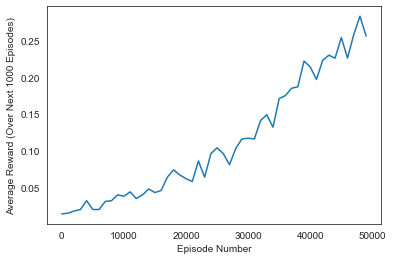

Best Average Reward over 1000 Episodes:  0.283


In [34]:
Q_sarsamax = q_learning(env, 50000, .01)


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A (Final state) = -1):
[[2 2 1 0]
 [1 0 1 0]
 [2 2 1 0]
 [0 2 2 0]]


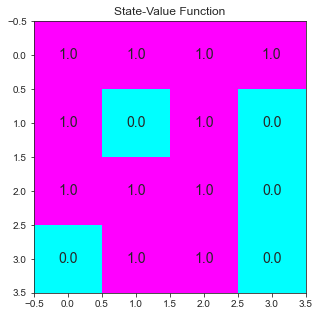

In [38]:
# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(16)]).reshape((4,4))
# check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A (Final state) = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(16)])

In [39]:
helper.print_actions()
print()

print("Policy:")
policy_sarsamax


Actions:
[0] Left
[1] Down
[2] Right
[3] Up

Policy:


array([[2, 2, 1, 0],
       [1, 0, 1, 0],
       [2, 2, 1, 0],
       [0, 2, 2, 0]], dtype=int64)

### Part 3: TD Control: Expected Sarsa (update_Q_expsarsa)

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [40]:
def update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]         # estimate in Q-table (for current state, action pair)
    policy_s = np.ones(nA) * eps / nA  # current policy (for next state S')
    policy_s[np.argmax(Q[next_state])] = 1 - eps + (eps / nA) # greedy action
    Qsa_next = np.dot(Q[next_state], policy_s)         # get value of state at next time step
    target = reward + (gamma * Qsa_next)               # construct target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [43]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Expected SARSA - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): step-size parameters for the update step
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes

    eps_decay = .99999
    eps = 1.
    eps_min = .05

    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0             # initialize score
        state = env.reset()   # start episode
        eps = max(eps*eps_decay, eps_min)                      # set the value of epsilon

        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            # update Q
            Q[state][action] = update_Q_expsarsa(alpha, gamma, nA, eps, Q, \
                                                 state, action, reward, next_state)        
            state = next_state              # S <- S'
            if done:
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  


Episode 50000/50000

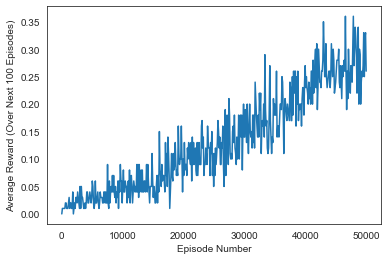

Best Average Reward over 100 Episodes:  0.36

Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A (Terminal State)= -1):
[[ 1  2  1  0  1  0  1  0  2  1  1  0]
 [ 0  2  2  0 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


ValueError: cannot reshape array of size 48 into shape (4,4)

In [45]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 50000, 1)


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A (Terminal State)= -1):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


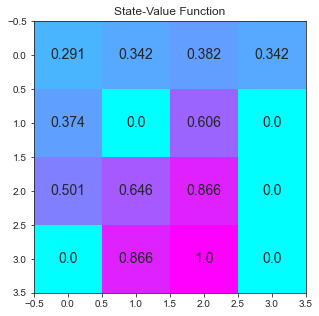

In [47]:
# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(16)]).reshape(4,4)

# check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A (Terminal State)= -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(16)])

In [48]:
helper.print_actions()
print()

print("Policy:")
policy_sarsamax


Actions:
[0] Left
[1] Down
[2] Right
[3] Up

Policy:


array([[2, 2, 1, 0],
       [1, 0, 1, 0],
       [2, 2, 1, 0],
       [0, 2, 2, 0]], dtype=int64)

---
__The end.__